<a href="https://colab.research.google.com/github/hujanais/reinforcement-learning/blob/master/Cart_Pole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
## Solving Cart-Pole with DQN.

In [15]:
from google.colab import output

import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
from collections import deque

from keras import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

import gym

import tensorflow as tf
device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: 


In [11]:
# some google drive magic.
#from google.colab import drive
#drive.mount('/content/drive')
#import os
#os.chdir('models')
#!ls

cart-pole.h5  ttt_20k.h5  ttt.h5


4
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38] [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38] 2
38.0


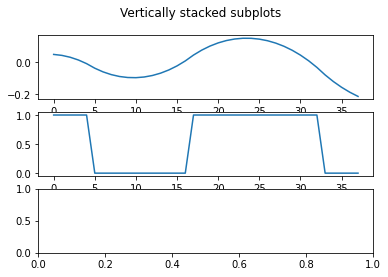

In [16]:
# explore the environment to see what does this game do.

env = gym.make('CartPole-v0')
state_size = env.observation_space.shape[0]
print(state_size)
print(env.observation_space.low, env.observation_space.high, env.action_space.n)
done = False
state = env.reset()

#  Type: Box(4)
#         Num	Observation               Min             Max
#         0	Cart Position             -4.8            4.8
#         1	Cart Velocity             -Inf            Inf
#         2	Pole Angle                -24 deg         24 deg
#         3	Pole Velocity At Tip      -Inf            Inf

angles = []
velocities = []
total_reward = 0
actions = []
while not done:

  angle = state[2]
  if (angle < 0):
    action = 0
  else:
    action = 1
  actions.append(action)

  next_state, reward, done, info = env.step(action)
  total_reward += reward

  angles.append(next_state[2])
  velocities.append(next_state[3])

  state = next_state

print (total_reward)
fig, axs = plt.subplots(3)
fig.suptitle('Vertically stacked subplots')
axs[0].plot(angles)
axs[1].plot(actions)

plt.show()


In [0]:
# The DQN Agent

class Agent:
  def __init__(self, state_size, action_size):

    # setup a deque for experience replay.
    self.memory = deque(maxlen=10000)
    self.batch_size = 32

    self.episode = 0

    # setup the state and action space.
    self.state_size = state_size
    self.action_size = action_size

    # neural network hyperparameters.
    self.learning_rate = 0.001

    # hyperparameters for epsilon decay
    self.gamma = 0.99  # discount rate
    self.epsilon = 1.0 # exploration threshold
    self.max_epsilon = 1.0
    self.min_epsilon = 0.01
    self.decay_rate = 0.0001 # exponential decay rate for explore-exploit

    # create a policy network and a target network.
    self.policy = self.__build_model()
    self.target_model = self.__build_model()

    self.target_update_cycles = 50  # the number of training after which to update the target network with the weights from the policy network

  # get the action with epsilon-greedy. used for training.
  # state is a one-hot-vector representation of the state.
  def act(self, state):
    exp_exp_tradeoff = random.uniform(0,1)
    if (exp_exp_tradeoff > self.epsilon):
      action = self.getGreedyAction(state) # exploit
    else:
      action = random.randrange(0, self.action_size)  # explore

    return action

  # get the greedy action
  def getGreedyAction(self, state):
    state_tensor = state.reshape(1, self.state_size)
    act_values = self.policy.predict(state_tensor)
    action = np.argmax(act_values[0])
    return action

  # exp => [state, action, reward, next_state, done]
  def remember(self, state, action, reward, next_state, done):
    self.memory.append((state, action, reward, next_state, done))

  # train the model using experience replay.
  def train(self):
    if (len(self.memory) >= self.batch_size):
      minibatch = random.sample(self.memory, self.batch_size)
      for state, action, reward, next_state, done in minibatch:
        target = reward # this is the definition of the terminal state.
        if not done:
          next_state_tensor = next_state.reshape(1, self.state_size)
          target = reward + self.gamma * np.amax(self.target_model.predict(next_state_tensor)[0])

        state_tensor = state.reshape(1, self.state_size)
        target_arr = self.policy.predict(state_tensor)

        target_arr[0][action] = target
        self.policy.fit(state_tensor, target_arr, verbose=0)

    self.decayEpsilon()

  # at the end of each training episode, decay the epsilon
  # to slowly facilitate more exploitation over exploration
  # We will also update the target network here.
  def decayEpsilon(self):
    self.episode += 1
    self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon)*np.exp(-self.decay_rate*self.episode)

    if (self.episode%self.target_update_cycles == 0):
      self.target_model.set_weights(self.policy.get_weights()) 

  # convert int to one hot vector
  def __to_onehot(self, value, size):
    one_hot_vector = np.zeros(size)
    one_hot_vector[value] = 1
    return one_hot_vector

  # build the neural network.
  def __build_model(self):
    model = Sequential()
    model.add(Dense(32, input_shape=(self.state_size,) , activation='relu')) # input_dim = 3 is equilavent with input_shape(3,)
    model.add(Dense(16, activation='relu'))
    model.add(Dense(self.action_size, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))

    return model

In [0]:
# Train the agent.

env = gym.make('CartPole-v0')
agent = Agent(4, 2)

rewardsArr = []
for episode in range(10000):
  done = False
  rewards = 0
  state = env.reset()
  while not done:
    action = agent.act(state)
    next_state, reward, done, info = env.step(action)

    agent.remember(state, action, reward, next_state, done)
    agent.train()

    rewards += reward
    state = next_state

  if(episode != 0 and episode%20==0):
    output.clear('status_text')
    print('Episode: {}.  Current Mean Score: {}'.format(episode, np.mean(rewardsArr[-20:]), end='\r'))
  
  # save the model once in a while
  if (episode != 0 and episode%1000==0):
    output.clear('status_text')
    agent.policy.save('cart-pole.h5')

  rewardsArr.append(rewards)

env.close()

plt.plot(rewardsArr)
plt.title('reward')
plt.xlabel('epoch')
plt.ylabel('score')
axs[0].plot(rewardsArr)
plt.show()

In [0]:
# Test the agent

# env = gym.make('CartPole-v0')
# load the pre-saved model
model = load_model('cart-pole.h5')

angles = []
velocities = []
total_reward = 0
actions = []

state = env.reset()
done = False
while not done:
  state_tensor = state.reshape(1,4)
  act_values = model.predict(state_tensor)
  action = np.argmax(act_values[0])
  next_state, reward, done, info = env.step(action)
  done = True if reward == 0 else False
  total_reward += reward

  actions.append(action)
  angles.append(next_state[2])
  velocities.append(next_state[3])

  env.render()
  state = next_state

print (total_reward)
fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
axs[0].plot(angles)
axs[1].plot(actions)

plt.show()

env.close()